In [1]:
import importlib
import torch
import torch.nn as nn

import tensorflow as tf

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import numpy as np
import cv2
import pandas as pd

import random

from NeuralGraph import NeuralGraph

C:\Users\Alec\AppData\Local\Temp\ipykernel_11896\1838974486.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [3]:
def split_dataset(x, y, valid_split=.2, test_split=.2):
    classes = np.unique(y)
    train_valid_split = round(len(classes)*(1-(valid_split+test_split)))
    valid_test_split = round(len(classes)*(1-test_split))

    train_classes = set(classes[:train_valid_split])
    valid_classes = set(classes[train_valid_split:valid_test_split])
    test_classes = set(classes[valid_test_split:])

    train = {i:[] for i in train_classes}
    valid = {i:[] for i in valid_classes}
    test = {i:[] for i in test_classes}

    for data, class_ in zip(x, y):
        if class_ in train_classes:
            train[class_].append(data)
        
        elif class_ in valid_classes:
            valid[class_].append(data)

        else:
            test[class_].append(data)

    for class_ in train_classes:
        train[class_] = np.stack(train[class_])

    for class_ in valid_classes:
        valid[class_] = np.stack(valid[class_])

    for class_ in test_classes:
        test[class_] = np.stack(test[class_])

    return train, valid, test

In [4]:
SIZE = 7

(x, y), (_, _) = tf.keras.datasets.mnist.load_data()
x = np.stack([cv2.resize(img/255.0, dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, mnist_valid, mnist_test = split_dataset(x, y, valid_split=.5, test_split=.5)

(x, y), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x = np.stack([cv2.resize(img/255.0, dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, fashion_valid, fashion_test = split_dataset(x, y, valid_split=.5, test_split=.5)

emnist = pd.read_csv("emnist-letters-train.csv").values
x, y = emnist[:, 1:], emnist[:, 0]
x = np.stack([cv2.resize(cv2.flip(cv2.rotate(img.reshape(28, 28)/255.0, cv2.ROTATE_90_CLOCKWISE), 1), dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

emnist_train, emnist_valid, emnist_test = split_dataset(x, y)

In [5]:
train = [emnist_train]
valid = [mnist_valid, fashion_valid, emnist_valid]

In [6]:
# BATCH_SIZE = 128
# TIME = 1
# DT = .25

# n_classes = 2
# device = "cuda" if torch.cuda.is_available() else "cpu"


# shape = [SIZE**2, 8, n_classes]
# n_nodes = sum(shape)
# connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

# print(len(connections))

# graph = NeuralGraph(n_nodes, SIZE**2, n_classes, connections,
#     ch_n=4, ch_e=4, value_init="random", init_value_std=.05, 
#     aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
#     device=device)

# log = []

In [7]:
# graph.inp_int = ES.ES_MLP(nn.Sequential(ES.ES_Linear(5, 4))).to(device)
# graph.label_int = ES.ES_MLP(nn.Sequential(ES.ES_Linear(5, 4))).to(device)
# graph.out_int = ES.ES_MLP(nn.Sequential(ES.ES_Linear(4, 1))).to(device)
# graph.messages = nn.ModuleList([ES.ES_MLP(nn.Sequential(
#     ES.ES_Linear(12, 16),
#     nn.ReLU(),
#     ES.ES_Linear(16, 12)
# ))]).to(device)
# graph.updates = nn.ModuleList([ES.ES_MLP(nn.Sequential(
#     ES.ES_Linear(12, 32),
#     nn.ReLU(),
#     ES.ES_Linear(32, 4)
# ))]).to(device)

# ruleset = [
#     graph.inp_int,
#     graph.label_int,
#     graph.out_int,
#     graph.messages[0],
#     graph.updates[0],
# ]
# # for model in ruleset:
# #     model.generate_epsilons(BATCH_SIZE)

In [47]:
import ES.ES_NeuralGraph
importlib.reload(ES.ES_NeuralGraph)

<module 'ES.ES_NeuralGraph' from 'c:\\Users\\Alec\\Documents\\GitHub\\NeuralGraphPaper\\ES\\ES_NeuralGraph.py'>

In [48]:
BATCH_SIZE = 16
TIME = 1
DT = .25

n_classes = 2
device = "cuda" if torch.cuda.is_available() else "cpu"


shape = [SIZE**2, 8, n_classes]
n_nodes = sum(shape)
connections = torch.Tensor([[sum(shape[:i])+x, sum(shape[:i+1])+y] for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])])

print(len(connections))

graph = ES.ES_NeuralGraph.NeuralGraph(n_nodes, SIZE**2, n_classes, connections,
    ch_n=4, ch_e=4, init_mode="random", init_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5).to(device)

log = []

408


In [49]:
TRAIN_EXAMPLES = 10
TEST_EXAMPLES = 5
# Reset optimizer
# optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(graph.parameters(), lr=1e-2)
criterion = nn.MSELoss()

STEPS = 10_000

log = []

In [50]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

def get_batch_data(dataset=train, batch_size=BATCH_SIZE, train_examples=TRAIN_EXAMPLES, test_examples=TEST_EXAMPLES):
    if type(dataset) != list:
        dataset = [dataset]
    set_ = np.random.randint(len(dataset), size=(batch_size))

    classes = np.stack([np.random.choice(list(dataset[i].keys()), size=(n_classes), replace=False) for i in set_])
    
    # This gets completely random examples
    # y_train = np.random.randint(n_classes, size=(batch_size, train_examples))
    # y_test = np.random.randint(n_classes, size=(batch_size, TEST_EXAMPLES))

    # This gets balanced random examples
    
    y_train = np.repeat(np.expand_dims(np.round(np.linspace(0, n_classes-1, train_examples)), axis=0), batch_size, axis=0).astype(np.int32)
    y_test = np.repeat(np.expand_dims(np.round(np.linspace(0, n_classes-1, test_examples)), axis=0), batch_size, axis=0).astype(np.int32)

    y_train = shuffle_along_axis(y_train, axis=1)
    y_test = shuffle_along_axis(y_test, axis=1)


    x_train = []
    for batch_classes, y, i in zip(classes, y_train, set_):
        x_train.append([])
        for class_ in batch_classes[y]:
            x_train[-1].append(random.choice(dataset[i][class_]))
        x_train[-1] = np.stack(x_train[-1])
    x_train = np.stack(x_train)

    x_test = []
    for batch_classes, y, i in zip(classes, y_test, set_):
        x_test.append([])
        for class_ in batch_classes[y]:
            x_test[-1].append(random.choice(dataset[i][class_]))
        x_test[-1] = np.stack(x_test[-1])
    x_test = np.stack(x_test)
    
    return torch.Tensor(x_train).to(device), torch.Tensor(y_train).long().to(device), torch.Tensor(x_test).to(device), torch.Tensor(y_test).long().to(device), classes

In [53]:
with torch.no_grad():
    bar = tqdm(range(1, STEPS+1))
    for step in bar:

        # Train step
        x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=train)
        y_input = nn.functional.one_hot(y_train, n_classes).float()
        y_label = nn.functional.one_hot(y_test, n_classes).float()

        graph.generate_epsilons(BATCH_SIZE)
        graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)

        graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True, edges=False, edges_at_end=True)
        pred = graph.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True, edges=False)

        acc = (pred.argmax(2) == y_test).float().mean()

        task_losses = torch.square(pred - y_label).mean(-1).mean(-1)
        graph.estimate_grads(task_losses)
        
        # print(task_losses)
        # assert False

        task_loss = task_losses.mean()
        overflow = graph.overflow()
        
        loss = task_loss + overflow
        optimizer.step()

        # Valid step (currently just validating with perturbations but could change to do not train_mode)
        x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=valid)
        y_input = nn.functional.one_hot(y_train, n_classes).float()
        y_label = nn.functional.one_hot(y_test, n_classes).float()

        graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)

        graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True, edges=False, edges_at_end=True)
        pred = graph.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True, edges=False)

        valid_acc = (pred.argmax(2) == y_test).float().mean()
        valid_loss = criterion(pred, y_label)


        # Save
        # if step % 500 == 0 and step != 0:
        #     graph.save(f"models/generalize_{step}.pt")

        entry = {'valid_loss':valid_loss.item(), 'valid_acc':valid_acc.item(), 'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item()}
        log.append(entry)
        bar.set_postfix({"valid_loss":np.mean([e["valid_loss"] for e in log[-10:]]), "valid_acc":np.mean([e["valid_acc"] for e in log[-10:]]), "loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"]})

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

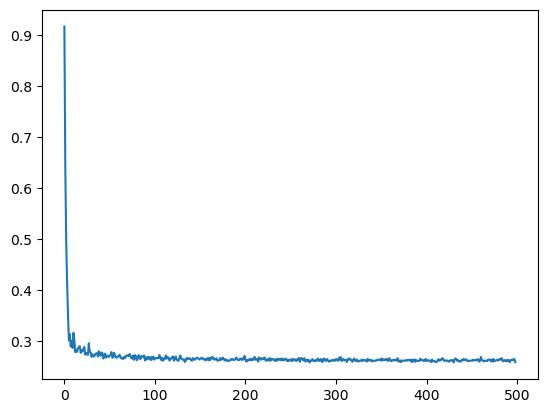

In [61]:
plt.plot([e["loss"] for e in log])

Original Tensor: tensor([4.2000, 1.8000, 7.5000, 2.3000, 5.1000])
Rank-normalized Tensor: tensor([0.4000, 0.8000, 0.0000, 0.6000, 0.2000])
